# SMS Spam Detection
    
    The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam.

    Acknowledgements

    The original dataset can be found in https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection. The creators would like to note that in case you find the dataset useful, please make a reference to previous paper and the web page: http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/ in your papers, research, etc.


### 1. Import Packages

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from numpy import mean
#import nltk
#nltk.download('stopwords')

### 2. Dataset Loading and Data Preprocessing
#### 2.1. Read dataset using pandas

In [42]:
sms = pd.read_csv("sms_spam.csv", encoding = "ISO-8859-1")
sms.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


#### 2.2. Remove redundant attributes

In [43]:
sms.drop(['Unnamed: 2', 'Unnamed: 3','Unnamed: 4'],axis=1,inplace= True)
sms.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


#### 2.3. Rename columns
v1 -> label, v2 -> message

In [44]:
sms.columns=['label','message']
sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


#### 2.4. Modify columns
Change ham to 0, and spam to 1 in Label Attribute.

In [45]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

ppc = preprocessing.LabelEncoder()
sms.label = ppc.fit_transform(sms.label) 

sms.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


#### 2.5. Add new column
Add message_len Attribute that is the length of the message.

In [46]:
count = 0
length = []
for i in sms['message']:
    length.append(len(i))
sms['length'] = length

sms.head()

,label,message,length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


#### 2.6. Histogram graph

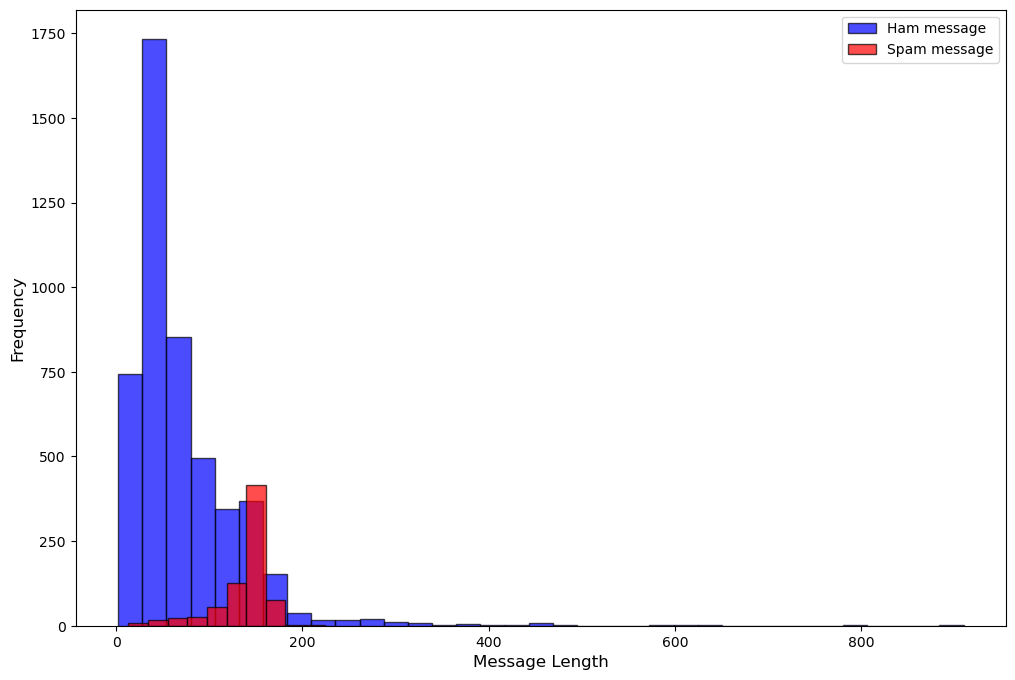

In [47]:
plt.figure(figsize=(12,8))
plt.hist(x='length', bins=35, data=sms[sms['label']==0], edgecolor='black',color = 'blue',label='Ham message', alpha=0.7)
plt.hist(x='length', bins=10, data=sms[sms['label']==1], edgecolor='black',color = 'red',label='Spam message',alpha=0.7)
plt.legend()
plt.xlabel('Message Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

#### 2.7. Preprocessing text 
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text

In [48]:
import string
from nltk.corpus import stopwords

def text_process(mess):
    STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]
    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    # Now just remove any stopwords
    return ' '.join([word for word in nopunc.split() if word.lower() not in STOPWORDS])

In [49]:
# Apply the above function to preprocess the text.
clean = []
for i in sms.message:
    clean.append(text_process(i).lower())
sms['clean_message'] = clean
sms = sms.drop(columns=['message'])
sms = sms.drop(columns=['length'])
count = 0
length = []
for i in sms.clean_message:
    length.append(len(i))
sms['length']=length
sms.head()

,label,clean_message,length
0,0,go jurong point crazy available bugis n great ...,82
1,0,ok lar joking wif oni,21
2,1,free entry wkly comp win fa cup final tkts 21s...,133
3,0,dun say early hor c already say,31
4,0,nah think goes usf lives around though,38


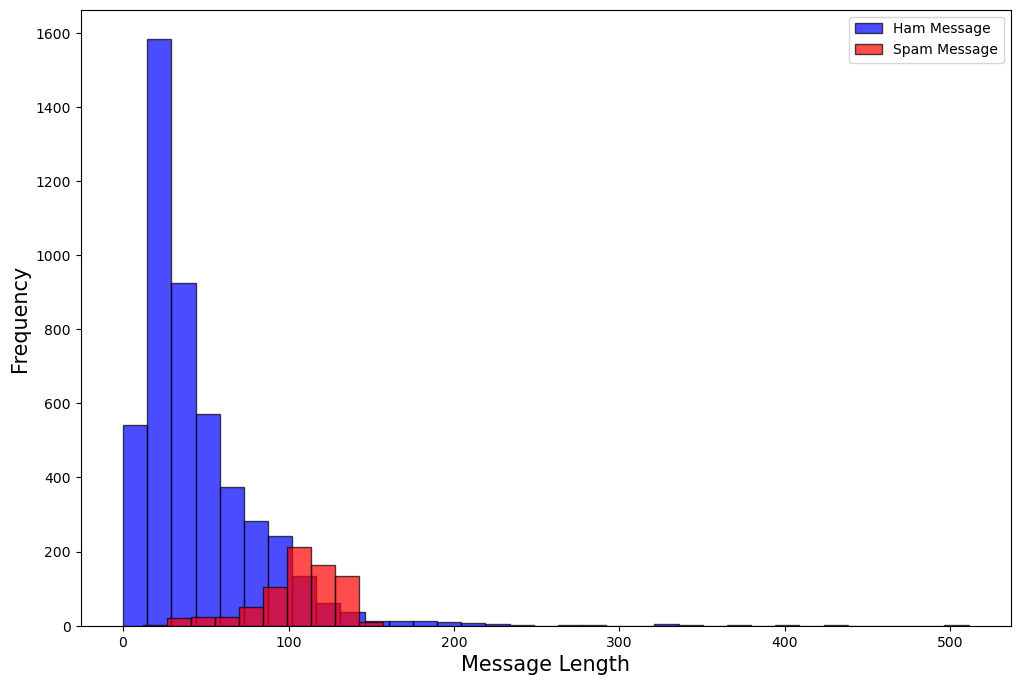

In [50]:
# Draw Histogram graph again with clean messages.
plt.figure(figsize=(12,8))
plt.hist(x='length',bins=35,data=sms[sms['label']==0],edgecolor='black',color='blue',label='Ham Message',alpha=0.7)
plt.hist(x='length',bins=10,data=sms[sms['label']==1],edgecolor='black',color='red',label='Spam Message',alpha=0.7)
plt.legend()
plt.xlabel('Message Length',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.show()

#### 2.8. Feature extraction using TfidfVectorizer

In [51]:
sms_tv = sms.copy()
tv = TfidfVectorizer(max_features=2**4)
temp = tv.fit_transform(sms_tv['clean_message']).toarray()

smstv = pd.DataFrame(temp)
sms_tv = pd.concat([sms_tv,smstv],axis = 1,sort = False)
y_tv = pd.DataFrame(sms_tv.label).to_numpy()
X_tv = sms_tv.drop(columns=['label','clean_message']).to_numpy()

In [52]:
kf = KFold(n_splits=5)
X_train_tv = []
y_train_tv = []
X_test_tv = []
y_test_tv = []
for train_index, test_index in kf.split(X_tv):
    X_train_tv.append(X_tv[train_index])
    y_train_tv.append(y_tv[train_index])
    X_test_tv.append(X_tv[test_index])
    y_test_tv.append(y_tv[test_index])

#### 2.9. Feature extraction using HashingVectorizer

In [53]:
sms_hv = sms.copy()
hv = HashingVectorizer(n_features=2**4)
temp = hv.fit_transform(sms_hv['clean_message']).toarray()

smshv = pd.DataFrame(temp)
sms_hv = pd.concat([sms_hv,smshv],axis = 1, sort=False)
y_hv = pd.DataFrame(sms_hv.label).to_numpy()
X_hv = sms_hv.drop(columns=['label','clean_message']).to_numpy()

In [54]:
kf = KFold(n_splits=5)
X_train_hv = []
y_train_hv = []
X_test_hv = []
y_test_hv = []
for train_index, test_index in kf.split(X_hv):
    X_train_hv.append(X_hv[train_index])
    X_test_hv.append(X_hv[test_index])
    y_train_hv.append(y_hv[train_index])
    y_test_hv.append(y_hv[test_index])

#### 2.10. Feature extraction using CountVectorizer

In [55]:
smscv = sms.copy()
cv = CountVectorizer(max_features=2**4)
temp = cv.fit_transform(smscv['clean_message']).toarray()

smscv_ = pd.DataFrame(temp)
smscv = pd.concat([smscv,smscv_],axis=1,sort = False)
y_cv = pd.DataFrame(smscv.label).to_numpy()
X_cv = smscv.drop(columns=['label','clean_message']).to_numpy()

In [56]:
kf = KFold(n_splits=5)
X_train_cv = []
y_train_cv = []
X_test_cv = []
y_test_cv = []
for train_index, test_index in kf.split(X_cv):
    X_train_cv.append(X_cv[train_index])
    X_test_cv.append(X_cv[test_index])
    y_train_cv.append(y_cv[train_index])
    y_test_cv.append(y_cv[test_index])

#### 2.11. Your contributions

    Create clean_msg_2 with your text_process function. 
    Then, apply feature extraction using TfidfVectorizer, HashingVectorizer and CountVectorizer
    Compare the result with the default text_process function. 

### 3. Spam detection

In [57]:
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn import metrics
import time

y = sms.label

# Using the decision tree classifier with default setting for training and predicting. 
model = tree.DecisionTreeClassifier()

#### 3.1. Using TF-IDF Vectorizer

    1. Using 5-fold for spliting the dataset 
    2. Add accuracy of each fold to acc_tv
    3. Caculate and print the proccessing time
    4. Print mean of accuracy

In [61]:
import time
acc_tv = []
start = time.time()
for i in range(5):
    model.fit(X_train_tv[i], y_train_tv[i])
    y_pred_tv = model.predict(X_test_tv[i])
    acc_tv.append(metrics.accuracy_score(y_test_tv[i],y_pred_tv))
end = time.time()
time = end - start
print("Time: ",time)
print("Accuracy of 5 fold: ",acc_tv)
print("Mean: ",mean(acc_tv))

Time:  0.03196239471435547
Accuracy of 5 fold:  [0.9183856502242153, 0.9399103139013453, 0.9434470377019749, 0.9299820466786356, 0.9389587073608617]
Mean:  0.9341367511734064


#### 3.2. Using Hashing Vectorizer
    1. Using 5-fold for spliting the dataset 
    2. Add accuracy of each fold to acc_hv
    3. Caculate and print the proccessing time
    4. Print mean of accuracy

In [62]:
import time
acc_hv = []
s = time.time()
for i in range(5):
    model.fit(X_train_hv[i], y_train_hv[i])
    y_pred_hv = model.predict(X_test_hv[i])
    acc_hv.append(metrics.accuracy_score(y_test_hv[i],y_pred_hv))
e = time.time()
time = e - s
print("Time: ",time)
print("Accuracy of 5 fold: ",acc_hv)
print("Mean: ",mean(acc_hv))

Time:  0.09065461158752441
Accuracy of 5 fold:  [0.8941704035874439, 0.9255605381165919, 0.9228007181328546, 0.9165170556552962, 0.9183123877917415]
Mean:  0.9154722206567856


#### 3.3. Using Count Vectorizer

    1. Using 5-fold for spliting the dataset 
    2. Add accuracy of each fold to acc_cv
    3. Caculate and print the proccessing time
    4. Print mean of accuracy

In [60]:
import time
acc_cv = []
s=time.time()
for i in range(5):
    model.fit(X_train_cv[i],y_train_cv[i])
    y_pred_cv = model.predict(X_test_cv[i])
    acc_cv.append(metrics.accuracy_score(y_test_cv[i],y_pred_cv))
e=time.time()
time=e-s
print("Time: ",time)
print("Accuracy of 5 fold: ",acc_cv)
print("Mean: ",mean(acc_cv))

Time:  0.03009819984436035
[0.9103139013452914, 0.9300448430493273, 0.9371633752244165, 0.9254937163375224, 0.9362657091561939]
Mean:  0.9278563090225503


#### 3.4. Ploting Accuracies in 5-Folds

(0.0, 1.3)

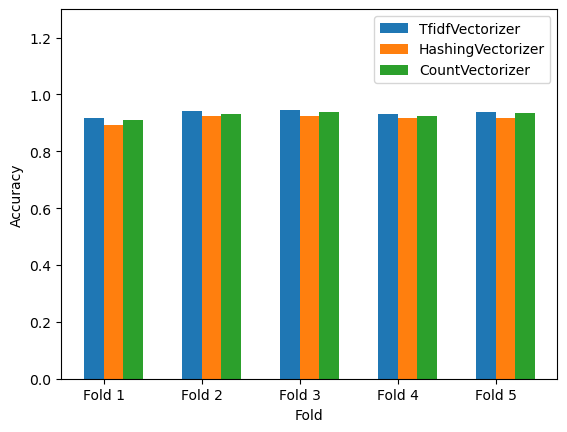

In [63]:
labels = ['Fold 1','Fold 2','Fold 3','Fold 4','Fold 5']
x = np.arange(len(labels))
width = 0.2
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, acc_tv, width)
rects2 = ax.bar(x + width/2, acc_hv, width)
rects3 = ax.bar(x + (width/2)*3, acc_cv, width)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Fold')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(['TfidfVectorizer', 'HashingVectorizer','CountVectorizer'])
ax.set_ylim([0,1.3])